# Import Required Libraries

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import dataset

In [62]:
df = pd.read_csv("bioactivity_preprocessed_data.csv")
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL76,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,12000.0,Inactive
1,CHEMBL4087097,FC(F)(F)c1cc(NCCCl)c2cccc(C(F)(F)F)c2n1,1400.0,Intermediate
2,CHEMBL4065673,OCCNc1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12,800.0,Active
3,CHEMBL4102529,NCCCNc1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12,2000.0,Intermediate
4,CHEMBL4084581,NCCNc1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12,800.0,Active


# Calculate Lipinski's Descriptors

The Lipinski rule of five, also known as Pfizer's rule of five or simply the rule of five (RO5), is a rule of thumb used in drug discovery to evaluate druglikeness or determine if a chemical compound with a certain pharmacological or biological activity has chemical properties and physical properties that would likely make it an orally active drug in humans.

The rule was formulated by Christopher A. Lipinski in 1997, based on the observation that most orally administered drugs are relatively small and moderately lipophilic molecules. Lipinski proposed that poor absorption or permeation is more likely when there are:

* More than 5 hydrogen bond donors (the total number of nitrogen–hydrogen and oxygen–hydrogen bonds)
* More than 10 hydrogen bond acceptors (all nitrogen or oxygen atoms)
* A molecular mass greater than 500 daltons
* A calculated octanol-water partition coefficient (Clog P) that does exceed 5

So, a drug must have the following properties:

* Hydrogen Bond Donors < 5
* Hydrogen Bond Acceptors < 10
* Molecular Mass < 500 daltons
* Calculated Octanol-water partition Coefficient (Clog P) < 5

## Installing Libraries Required and Calculating Lipinski's Descriptors

In [64]:
## Installing rdkit
# !pip install rdkit-pypi

In [65]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [66]:
## Define a Function to extract properties Using Cannonical Smiles
##LogP is the solubility of the molecules
def lipinski(smiles):
    moldata = []
    for smile in smiles:
        mol = Chem.MolFromSmiles(smile)
        moldata.append(mol)

    desc_molwt = [Descriptors.MolWt(mol) for mol in moldata]
    desc_logP = [Descriptors.MolLogP(mol) for mol in moldata]
    desc_Hbaccept = [Lipinski.NumHAcceptors(mol) for mol in moldata]
    desc_Hbdonor = [Lipinski.NumHDonors(mol) for mol in moldata]

    data = {
        'MolWt': desc_molwt,
        'LogP': desc_logP,
        'NumHDonors': desc_Hbdonor,
        'NumHAcceptors': desc_Hbaccept
    }

    return pd.DataFrame(data)

In [67]:
df_lipinski = lipinski(df.canonical_smiles)
df_lipinski.head()

,MolWt,LogP,NumHDonors,NumHAcceptors
0,319.880,4.8106,1,3
1,342.670,4.9231,1,2
2,324.224,3.6766,2,3
3,337.267,4.0331,2,3
4,323.240,3.6430,2,3


# Forming New DataFrame For Further Processes

## Merging DataFrames

In [69]:
df_merged = pd.concat([df, df_lipinski], axis = 1)
df_merged.head()

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MolWt,LogP,NumHDonors,NumHAcceptors
0,CHEMBL76,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,12000.0,Inactive,319.880,4.8106,1,3
1,CHEMBL4087097,FC(F)(F)c1cc(NCCCl)c2cccc(C(F)(F)F)c2n1,1400.0,Intermediate,342.670,4.9231,1,2
2,CHEMBL4065673,OCCNc1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12,800.0,Active,324.224,3.6766,2,3
3,CHEMBL4102529,NCCCNc1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12,2000.0,Intermediate,337.267,4.0331,2,3
4,CHEMBL4084581,NCCNc1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12,800.0,Active,323.240,3.6430,2,3


## Data Processing

### Normalize the standard value to its logarithmic value

In [70]:
## Conversion from nano-molar to molar and apply -log10
normalized_std = [x if x<=100000000 else 100000000 for x in df['standard_value'].values]
std_molar = [-np.log10(x*10**-9) for x in normalized_std]
df_final = df_merged.copy(deep = True)
df_final["pEC50"] = std_molar
df_final.drop("standard_value", axis = 1, inplace = True)
df_final.head()

,molecule_chembl_id,canonical_smiles,bioactivity_class,MolWt,LogP,NumHDonors,NumHAcceptors,pEC50
0,CHEMBL76,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,Inactive,319.880,4.8106,1,3,4.920819
1,CHEMBL4087097,FC(F)(F)c1cc(NCCCl)c2cccc(C(F)(F)F)c2n1,Intermediate,342.670,4.9231,1,2,5.853872
2,CHEMBL4065673,OCCNc1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12,Active,324.224,3.6766,2,3,6.096910
3,CHEMBL4102529,NCCCNc1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12,Intermediate,337.267,4.0331,2,3,5.698970
4,CHEMBL4084581,NCCNc1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12,Active,323.240,3.6430,2,3,6.096910


### Remove the Intermediate Bioactivity

In [71]:
df_filtered_bioactivity = df_final[df_final["bioactivity_class"]!= "Intermediate"]
df_filtered_bioactivity.head()

,molecule_chembl_id,canonical_smiles,bioactivity_class,MolWt,LogP,NumHDonors,NumHAcceptors,pEC50
0,CHEMBL76,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,Inactive,319.880,4.8106,1,3,4.920819
2,CHEMBL4065673,OCCNc1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12,Active,324.224,3.6766,2,3,6.096910
4,CHEMBL4084581,NCCNc1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12,Active,323.240,3.6430,2,3,6.096910
6,CHEMBL76,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,Inactive,319.880,4.8106,1,3,4.920819
8,CHEMBL4081503,O=[N+]([O-])c1ccc(C=NCCNc2ccnc3cc(Cl)ccc23)o1,Active,344.758,3.9204,1,6,6.096910


# Exploratory Data Analysis

In [75]:
df_filtered_bioactivity["MolWt"].max()

889.1090000000002

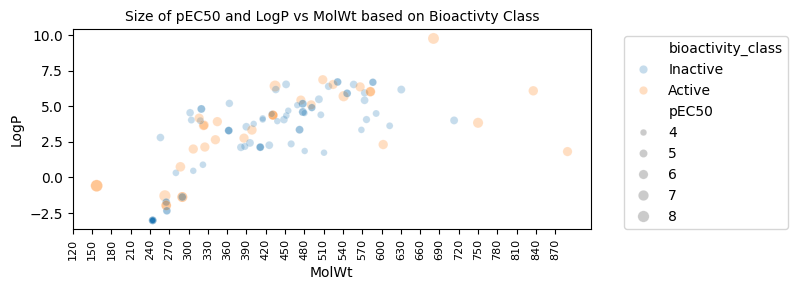

In [79]:
plt.figure(figsize = (8,3))
sns.scatterplot(x = df_filtered_bioactivity["MolWt"], 
                y = df_filtered_bioactivity["LogP"], 
                size = df_filtered_bioactivity["pEC50"], 
                hue = df_filtered_bioactivity["bioactivity_class"],alpha = 0.25)
xticks = np.arange(120, 900, step = 30)
plt.xticks(ticks = xticks, rotation =90, fontsize = 8)
plt.title("Size of pEC50 and LogP vs MolWt based on Bioactivty Class", fontsize = 10)
plt.legend(bbox_to_anchor = (1.05, 1))
plt.tight_layout()
plt.show()

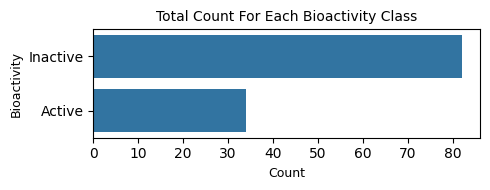

In [80]:
## Number of datapoints for each bioactivity classes
plt.figure(figsize = (5,2))
sns.countplot(df_filtered_bioactivity["bioactivity_class"])
plt.title("Total Count For Each Bioactivity Class", fontsize = 10)
plt.xlabel("Count", fontsize = 9)
plt.ylabel("Bioactivity", fontsize = 9)
plt.tight_layout()
plt.show()

## Detecting Outliers

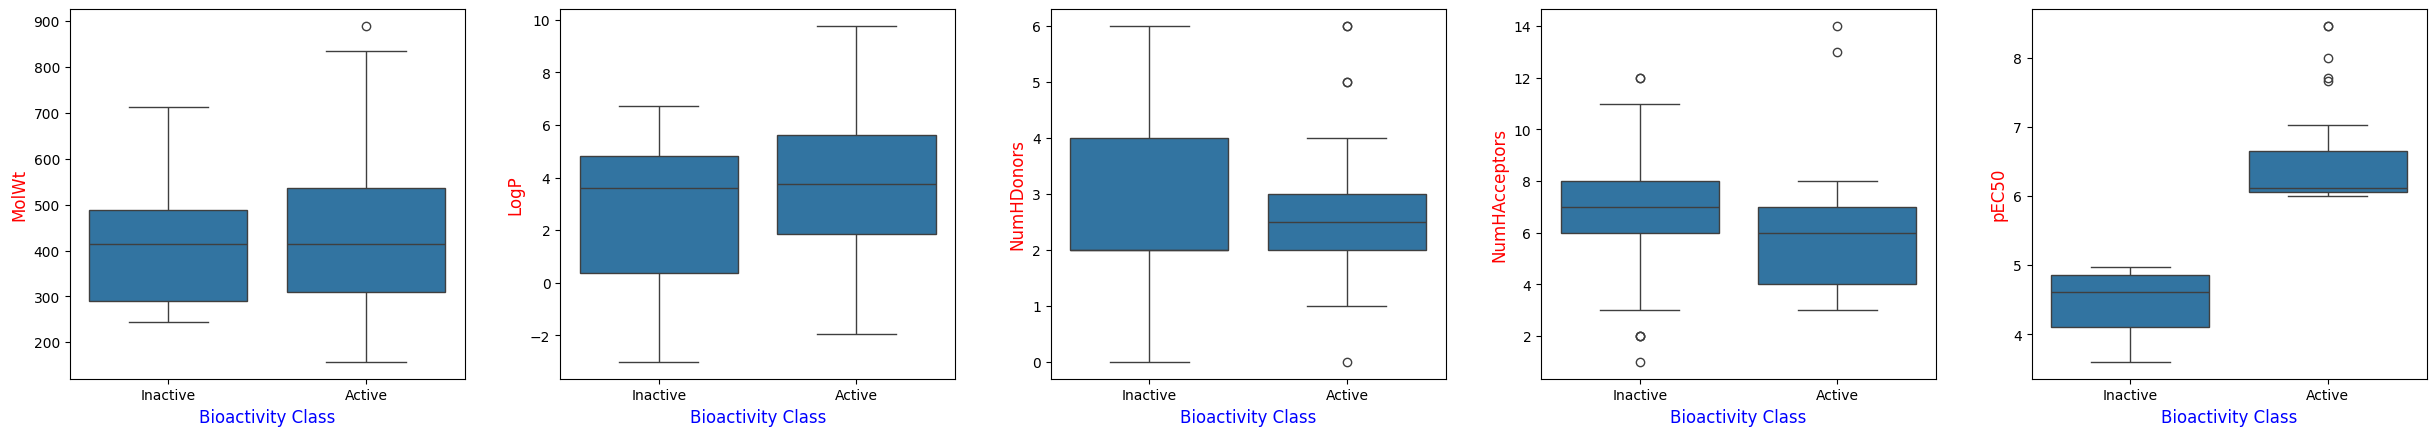

In [81]:
number_data = df_filtered_bioactivity.select_dtypes("number")
nrows = 1
ncols = len(number_data.columns)
fig, ax = plt.subplots(nrows, ncols, figsize = (25,5))

if ncols == 1:
    ax = [ax]

for i in range(nrows * ncols):
    sns.boxplot(data = df_filtered_bioactivity, x = "bioactivity_class", y = number_data.columns[i], ax = ax[i])
    ax[i].set_xlabel("Bioactivity Class", fontsize = 12, color = "b")
    ax[i].set_ylabel(number_data.columns[i], fontsize = 12, color = "r")

fig.tight_layout(pad = 3.0)
plt.show()

**There are some outliers in the Molwt, NumHDonors, NumHAcceptors and pEC50 Columns mostly for active bioactivity class**

# Statistical Test

## Mann - Whitney U Test

* **Purpose**: Used to assess the difference between two independent groups.
* **Fields of Application**: Economics, biological sciences, epidemiology.
* **Suitable Conditions**:
    - Groups have low numbers of individuals (usually less than 30).
    - Data are continuous.
    - Data are not normally distributed.


**Assumptions of Mann-Whitney U Test**

**Type of Variable**:
* The variable must be continuous (e.g., age, weight, height, heart rate).

**Data Distribution**:
* Assumes a non-Normal (skewed) distribution.
* If data are normally distributed, use the unpaired Student’s t-test instead.

**Shape of Distribution**:
* Data in both groups should have a similar shape.

**Sample Independence**:
* Groups should be two randomly selected independent samples with no relationship.
* If samples are paired, use a paired samples t-test instead.
  
**Sample Size**:
* Requires more than 5 observations in each group for a valid test.

Source: https://www.technologynetworks.com/informatics/articles/mann-whitney-u-test-assumptions-and-example-363425

In [1]:
def MannWhitneyUTest(dataframe, descriptor, alpha:float = 0.05):
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import mannwhitneyu

    ##Random Number Seed
    seed(42)
    ## Select the descriptor value for active bioactivity
    selected = dataframe[[descriptor, "bioactivity_class"]]
    active = selected[selected["bioactivity_class"] == "Active"][descriptor]

    ## Select the descriptor for inactive bioactivity
    inactive = selected[selected["bioactivity_class"] == "Inactive"][descriptor]

    ## Compare Sample: Are the two populations equal
    ##H0: Yes, they are equal
    ##H1: No, they are not equal
    
    stat, p = mannwhitneyu(active, inactive)
    print("Statistics = %.3f, p = %.3f" %(stat, p))

    ## Interpret
    if p>alpha:
        interpretation = "Same Distribution(Accept H0)"
    else:
        interpretation = "Different Distribution (Accept H1)"


    results = pd.DataFrame({
        "Descriptor": descriptor,
        "Statistics": stat,
        "p-val": p,
        "alpha":alpha,
        "Interpretation": interpretation}, index = [0])
    results.to_csv(f"mannwhitney_{descriptor}.csv")
    return results

In [83]:
for col in df_filtered_bioactivity.select_dtypes("number"):
    result = MannWhitneyUTest(df_filtered_bioactivity, col)
    print(result.to_string(), "\n")
    print("-"*50)
    
    

Statistics = 1501.000, p = 0.518
  Descriptor  Statistics     p-val  alpha                Interpretation
0      MolWt      1501.0  0.517911   0.05  Same Distribution(Accept H0) 

--------------------------------------------------
Statistics = 1555.000, p = 0.330
  Descriptor  Statistics     p-val  alpha                Interpretation
0       LogP      1555.0  0.329861   0.05  Same Distribution(Accept H0) 

--------------------------------------------------
Statistics = 1555.000, p = 0.311
   Descriptor  Statistics     p-val  alpha                Interpretation
0  NumHDonors      1555.0  0.310506   0.05  Same Distribution(Accept H0) 

--------------------------------------------------
Statistics = 933.500, p = 0.004
      Descriptor  Statistics    p-val  alpha                      Interpretation
0  NumHAcceptors       933.5  0.00445   0.05  Different Distribution (Accept H1) 

--------------------------------------------------
Statistics = 2788.000, p = 0.000
  Descriptor  Statistics    

**Insights:**

* There is a significant difference between active and inactive drugs based on NumHAcceptors nad pEC50 parameters.